<h1 style="color:#191970; font-size:38px">MIMO-Gradient-Descent</h1>

<h1 style="color:#006400">Libraries</h1>

In [1]:
import numpy as np
from numpy.linalg import inv
from commpy.modulation import QAMModem
import matplotlib.pyplot as plt
import decimal
from decimal import getcontext
getcontext().Emax = 600000000000

<h1 style="color:#006400">Functions</h1>

In [2]:
import import_ipynb
from Utils import Basic_Nonlinear_Distortion_Model
from Utils import hpa_sspa_modif_rapp
from Utils import find_K0_sigma2_d

importing Jupyter notebook from Utils.ipynb


Using TensorFlow backend.


<h1 style="color:#006400">Variables</h1>

In [3]:
IBO=3
p=1.1
q=4
Vsat=1.9
G=16
A=-345
B=0.17
Mr=10
Mt=100
M=16
N_bits=Mr*np.log2(M)
SNRdb=decimal.Decimal(60000000000)
Niter=50
mu1=0.0017
lamda=0.00071
mu2=1
eps=1e-2

<h1 style="color:#006400">Initialization</h1>

In [4]:
N_bits=Mr*np.log2(M)
MSE=np.zeros((Mt,50))
x_gd_amp0=np.zeros((Mt,1))
y_gd_r0=np.zeros([Mt,100])
PAPR_GD=np.zeros((Mt,1))
MUIgdi= np.zeros((Mt,1))
SERgdi=np.zeros((Mt,1))
BERgdi=np.zeros((Mt,1))
x_gd=np.zeros([Mt,1])
gdx1=np.zeros([Mt,Niter])
d=np.zeros([Mt,1])

<h1 style="color:#006400">Basic_Nonlinear_Distortion_Model</h1>

In [5]:
K0, sigma_2d=Basic_Nonlinear_Distortion_Model(A,B,q,p,G,Vsat,IBO)

<h1 style="color:#006400">16-QAM-Modulation/Demodulation</h1>

In [6]:
for monte in range(100):
    bits = np.random.randint(1, size=int(N_bits))
    QAM16 = QAMModem(16)
    z=QAM16.modulate(bits)
    H=(1/np.sqrt(2*Mt))*(np.random.randn(Mr,Mt)+1j*np.random.randn(Mr,Mt))
    zf=np.transpose(np.conj(H)).dot(inv(H.dot(np.transpose(np.conj(H)))))
    x_zf=zf.dot(z)
    recieve=H.dot(x_zf)
    A=QAM16.demodulate(recieve, demod_type='hard', noise_var=0)

<h1 style="color:#006400">Gradient Descent Algorithm</h1>

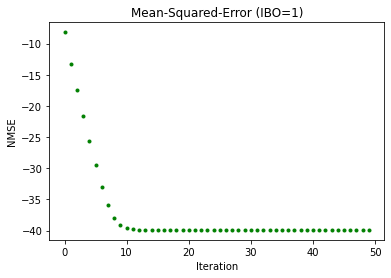

In [7]:
   for i in range(Niter):
        Z = np.reshape(z, (1, 10)).T
        gdx1=2*np.conj(K0*np.transpose(H)).dot(K0*H.dot(x_gd)+H.dot(d)-Z)
        x_gd=x_gd-mu1*gdx1
        ## HPA 
        val_IBO_m1dB=((1/np.sqrt(10**-0.1))**(2*p)-1)**(1/(2*p))*Vsat/(G)
        coeff_IBO_m1dB=val_IBO_m1dB*np.sqrt((1/np.var(x_gd)))*np.sqrt(10**(-IBO/10))
        vin2=coeff_IBO_m1dB*x_gd
        vout2=hpa_sspa_modif_rapp(vin2,Vsat,p,q,G,A,B)
        y_gd =np.array( vout2/(coeff_IBO_m1dB))
        K0,sigma2_d=find_K0_sigma2_d (vin2,vout2)
        d =vout2-K0*vin2
        MSE=np.mean(np.abs(H.dot(y_gd)-Z)**2)/(np.mean(np.abs(Z)**2))
        MMSE=np.mean( MSE)
        NMSE=10*np.log10(MMSE)
        plt.figure
        plt.title('Mean-Squared-Error (IBO=1)')
        plt.xlabel('Iteration')
        plt.ylabel('NMSE')
        plt.plot(i,NMSE,color='green', marker='.', linestyle='dashed')
MSE=MSE

<h1 style="color:#006400">Hight Power Amplifier </h1>

In [8]:
    PAPR_GD[monte]=np.max(np.abs(x_gd)**2)/np.mean(np.abs(x_gd)**2)
    coeff_IBO_m1dB=val_IBO_m1dB*np.sqrt((1/np.var(x_gd)))*np.sqrt(10**(-IBO/10))
    vin3=coeff_IBO_m1dB*x_gd
    vout3=hpa_sspa_modif_rapp(vin3,Vsat,p,q,G,A,B)
    x_gd_amp = vout3
    x_gd_amp0 =x_gd_amp
            

<h1 style="color:#006400">Channel </h1>

In [9]:
    y_gd=H.dot(x_gd_amp)

<h1 style="color:#006400">Gaussian Noise</h1>

In [10]:
    SNRlin=pow(10,SNRdb/10) 
    sigmas2=np.var(Z)
    sigma2=(sigmas2/(2*float(SNRlin)))
    sigmas2gd=np.var(x_gd_amp)
    sigma2gd=(sigmas2gd/(2*float(SNRlin)))
    wgd = np.sqrt(sigma2gd)*(np.random.randn(Mr,1)+1j*np.random.randn(Mr,1))
    y_gd_r = y_gd + wgd
    y_gd_r = y_gd_r/coeff_IBO_m1dB
    y_gd_r0=y_gd_r

<h1 style="color:#006400">Simulation Results</h1>

In [11]:
    MUIgdi[monte]=np.mean(np.abs(y_gd_r-Z)**2)/np.mean(np.abs(Z)**2)   
    BERgdi[monte]=np.sum(A!=bits)/(Mr*np.log2(M))
    SERgdi[monte]=np.log2(M)*BERgdi[monte]  

### 1. Peak-to-Average Power Ratio

In [12]:
print(np.mean(PAPR_GD)) 

0.049492922143302955


### 2. Multi-User Interference

In [13]:
MUIgd = 10*np.log10(np.mean(MUIgdi))
print(MUIgd)

-59.88175939465297


### 3. Squared Bit Error Rate

In [14]:
SERgd =np.mean(SERgdi)
print(SERgd)

0.0


### 4. Bit Error Rate

In [15]:
BERgd = np.mean(BERgdi)
print(BERgd)

0.0
